In [22]:
import alpaca_trade_api as tradeapi
import pandas as pd
from datetime import datetime, timedelta
from utils_day_trade import backtest_plot

In [23]:
import alpaca_trade_api as tradeapi

API_KEY = 'PK55SJLN5X7L81OB9D1P'
SECRET_KEY = '3iWrQIdPWUlbNFV1wNcBzGx2JReYbMEQOXtx9rH0'
BASE_URL = 'https://paper-api.alpaca.markets'  # for paper trading

api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

# Get your account info
account = api.get_account()
print(account.status)


ACTIVE


In [24]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

start_date_str = '2024-07-07' #'2025-07-01' # 

# ✅ 修复 RFC3339 格式要求：无微秒、带 Z 时区后缀
end_date_str = datetime.utcnow().replace(microsecond=0).isoformat() + 'Z'
ticker = "NVDL"
bars = api.get_bars(
    symbol=ticker,
    timeframe='5Min',
    start=start_date_str,
    end=end_date_str,
    feed = 'iex'
).df

# 如果是 MultiIndex
if isinstance(bars.index, pd.MultiIndex):
    bars = bars[bars.index.get_level_values('symbol') == ticker]

print(bars.tail())

                           close   high    low  trade_count   open  volume  \
timestamp                                                                    
2025-07-09 19:15:00+00:00  74.60  74.60  74.50            3  74.50     400   
2025-07-09 19:20:00+00:00  74.81  74.81  74.80            2  74.80     400   
2025-07-09 19:25:00+00:00  74.58  74.77  74.58            3  74.77     326   
2025-07-09 19:30:00+00:00  74.50  74.53  74.50            4  74.53     700   
2025-07-09 19:35:00+00:00  74.50  74.56  74.48            4  74.48     700   

                                vwap  
timestamp                             
2025-07-09 19:15:00+00:00  74.550000  
2025-07-09 19:20:00+00:00  74.802500  
2025-07-09 19:25:00+00:00  74.643333  
2025-07-09 19:30:00+00:00  74.508571  
2025-07-09 19:35:00+00:00  74.514286  


In [25]:
# 下载 5 天的 5分钟级数据
data = bars
df = data.reset_index()
print('lastest time')
print(list(df['timestamp'])[-1])

lastest time
2025-07-09 19:35:00+00:00


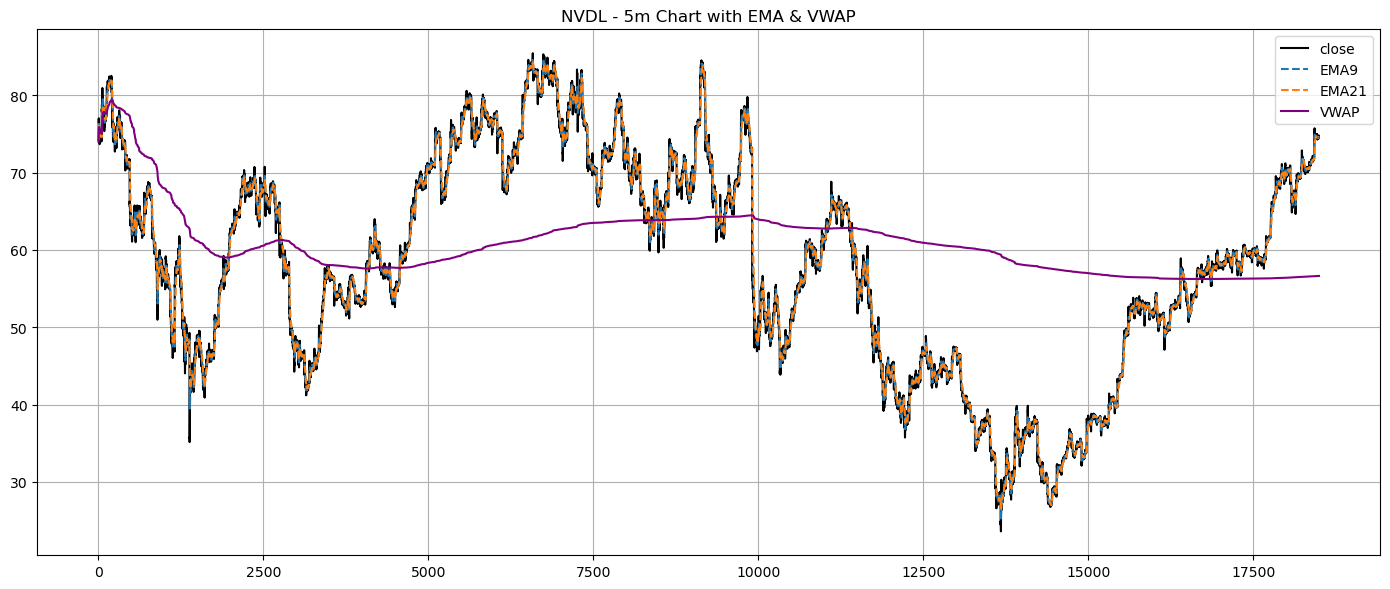

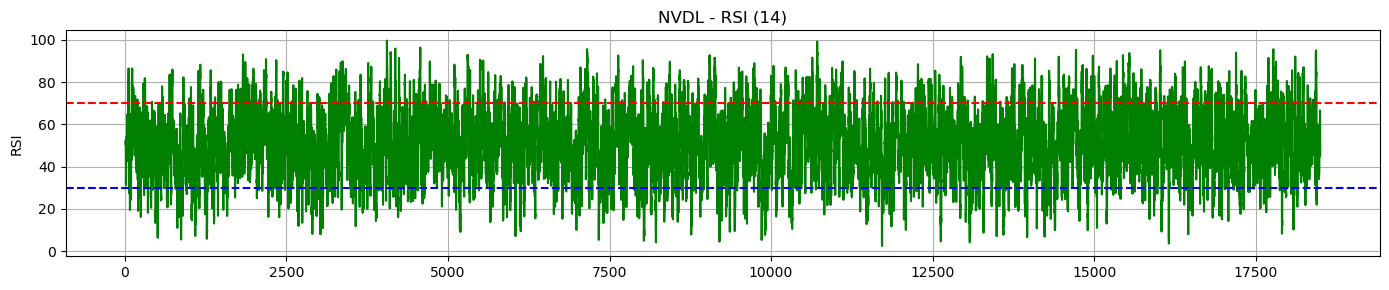

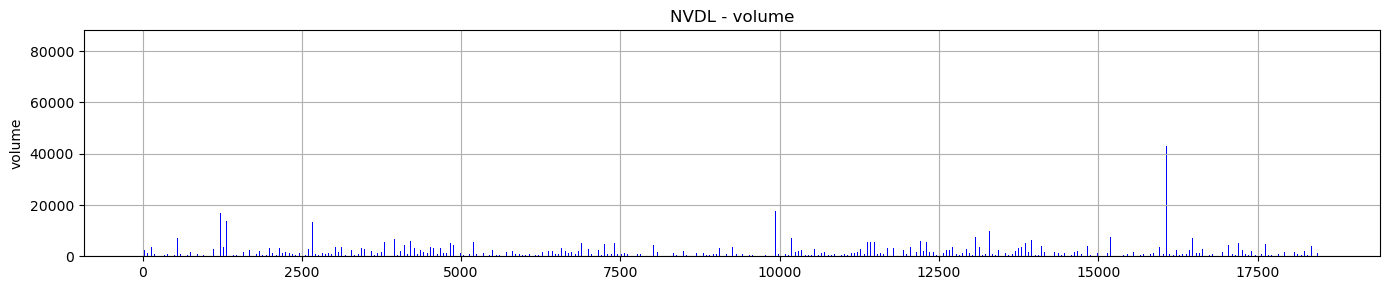

In [26]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt



# 下载 5 天的 5分钟级数据
# data = yf.download(ticker, interval="5m", period="max")
#df = data.reset_index().droplevel(1, axis=1)
# 计算技术指标
df["EMA9"] = df["close"].ewm(span=9).mean()
df["EMA21"] = df["close"].ewm(span=21).mean()

# RSI
delta = df["close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

# VWAP
df["Typical_Price"] = (df["high"] + df["low"] + df["close"]) / 3
df["Cum_TP_Vol"] = (df["Typical_Price"] * df["volume"]).cumsum()
df["Cum_volume"] = df["volume"].cumsum()
df["VWAP"] = df["Cum_TP_Vol"] / df["Cum_volume"]

# 主图
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["close"], label="close", color="black")
plt.plot(df.index, df["EMA9"], label="EMA9", linestyle="--")
plt.plot(df.index, df["EMA21"], label="EMA21", linestyle="--")
plt.plot(df.index, df["VWAP"], label="VWAP", color="purple")
plt.title(f"{ticker} - 5m Chart with EMA & VWAP")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# RSI 图
plt.figure(figsize=(14, 3))
plt.plot(df.index, df["RSI"], label="RSI", color="green")
plt.axhline(70, color="red", linestyle="--")
plt.axhline(30, color="blue", linestyle="--")
plt.title(f"{ticker} - RSI (14)")
plt.ylabel("RSI")
plt.grid()
plt.tight_layout()
plt.show()

# volumn plot
plt.figure(figsize=(14, 3))
plt.bar(df.index, df["volume"], width=0.3, color="blue")
plt.title(f"{ticker} - volume")
plt.ylabel("volume")
plt.grid(True)
plt.tight_layout()
plt.show()

## original way

🔎 回测总结
                    Buy_Time                 Sell_Time  Buy_Price  Sell_Price  \
0  2024-07-12 13:55:00+00:00 2024-07-12 14:15:00+00:00     75.980       74.84   
1  2024-07-18 19:40:00+00:00 2024-07-18 19:50:00+00:00     65.045       64.69   
2  2024-07-19 19:10:00+00:00 2024-07-19 19:30:00+00:00     62.840       62.31   
3  2024-08-09 14:10:00+00:00 2024-08-09 14:15:00+00:00     47.180       46.84   
4  2024-08-09 17:05:00+00:00 2024-08-09 17:10:00+00:00     46.180       46.72   
..                       ...                       ...        ...         ...   
61 2025-06-17 16:00:00+00:00 2025-06-17 16:05:00+00:00     59.680       59.73   
62 2025-06-27 13:35:00+00:00 2025-06-27 13:40:00+00:00     69.250       68.92   
63 2025-06-27 19:40:00+00:00 2025-06-27 19:45:00+00:00     70.000       70.08   
64 2025-06-30 19:15:00+00:00 2025-06-30 19:20:00+00:00     70.390       70.54   
65 2025-07-01 16:40:00+00:00 2025-07-01 16:45:00+00:00     66.790       67.05   

      Return        

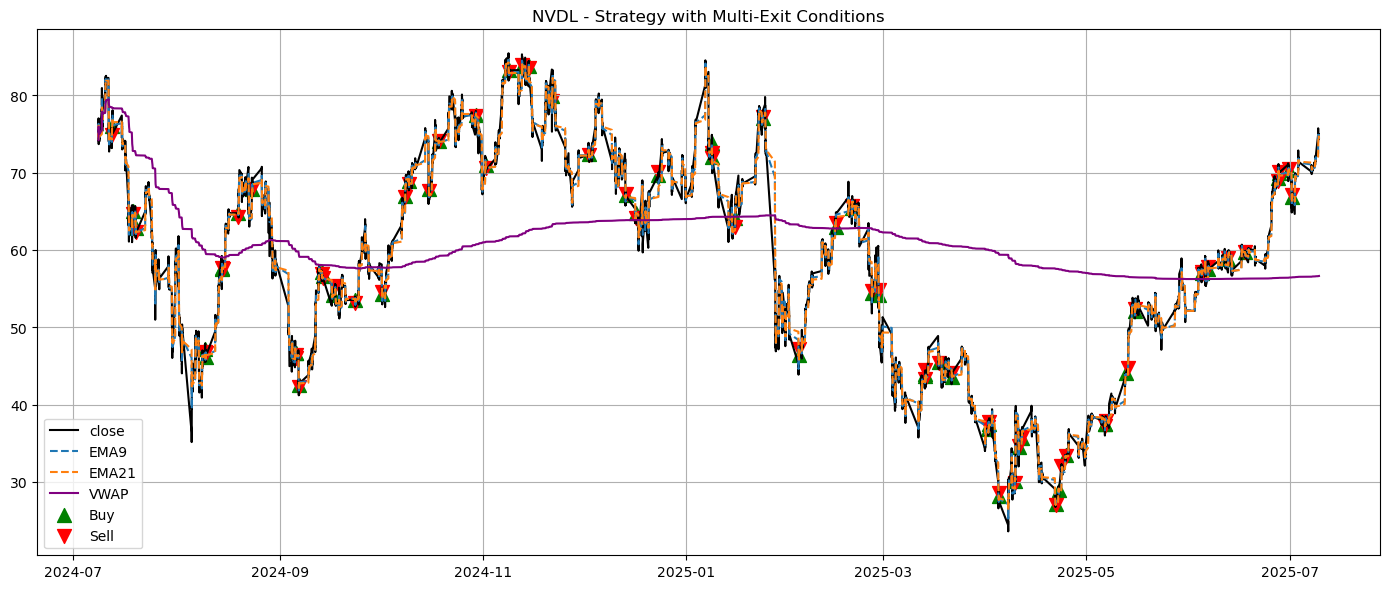

In [27]:
from utils_day_trade import generate_signals_and_backtest_delay, get_latest_data
import pytz
ticker='NVDL'
df = get_latest_data(ticker,start_date=start_date_str)
eastern = pytz.timezone('US/Eastern')
df,trades = generate_signals_and_backtest_delay(df,0)
    

backtest_plot(ticker,df,trades)

## 15min delay

NVDL
🔎 回测总结
                    Buy_Time                 Sell_Time  Buy_Price  Sell_Price  \
0  2024-07-12 14:10:00+00:00 2024-07-12 14:30:00+00:00     75.670      75.850   
1  2024-07-18 19:55:00+00:00 2024-07-19 13:45:00+00:00     65.700      65.300   
2  2024-07-19 19:25:00+00:00 2024-07-19 19:50:00+00:00     62.900      61.965   
3  2024-08-09 14:25:00+00:00 2024-08-09 14:45:00+00:00     45.835      46.560   
4  2024-08-09 17:20:00+00:00 2024-08-09 17:45:00+00:00     46.710      46.850   
..                       ...                       ...        ...         ...   
61 2025-06-17 16:15:00+00:00 2025-06-17 16:45:00+00:00     59.770      59.510   
62 2025-06-27 13:50:00+00:00 2025-06-27 14:10:00+00:00     68.610      69.410   
63 2025-06-27 19:55:00+00:00 2025-06-30 12:40:00+00:00     70.310      70.900   
64 2025-06-30 19:30:00+00:00 2025-06-30 19:50:00+00:00     70.370      70.940   
65 2025-07-01 16:55:00+00:00 2025-07-01 17:15:00+00:00     67.230      67.500   

      Return   

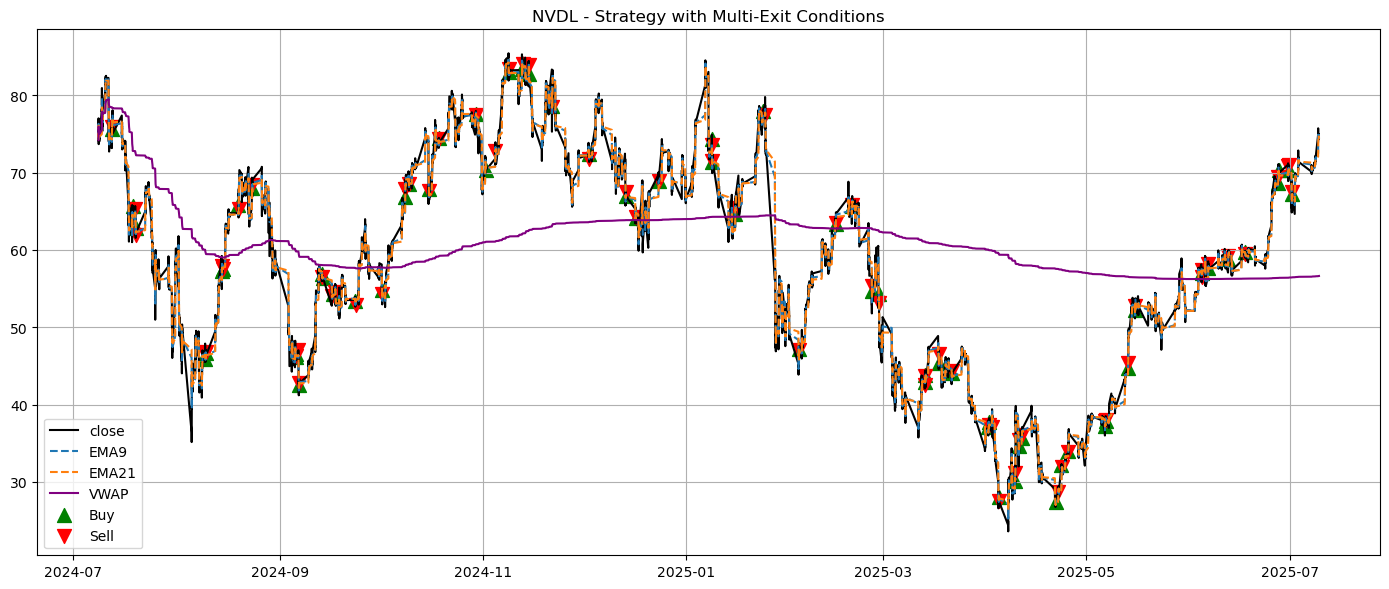

In [28]:

from utils_day_trade import generate_signals_and_backtest_delay
#['TSLL','QQQM','NVDL','AAPL']: 
for ticker in  ['NVDL']: #['TSLL','NVDL','NVDA','TQQQ','GLD']:
 
    print(ticker)
    df = get_latest_data(ticker,start_date=start_date_str)
    df,trades = generate_signals_and_backtest_delay(df,3)

    backtest_plot(ticker,df,trades)


## rsi method

NVDL
🔎 回测总结
                     Buy_Time                 Sell_Time  Buy_Price  \
0   2024-07-08 15:50:00+00:00 2024-07-08 16:30:00+00:00     75.330   
1   2024-07-09 18:00:00+00:00 2024-07-09 18:50:00+00:00     76.645   
2   2024-07-11 18:45:00+00:00 2024-07-11 19:20:00+00:00     74.930   
3   2024-07-15 14:25:00+00:00 2024-07-15 15:05:00+00:00     75.050   
4   2024-07-15 17:05:00+00:00 2024-07-15 17:25:00+00:00     73.780   
..                        ...                       ...        ...   
356 2025-07-07 14:05:00+00:00 2025-07-07 14:45:00+00:00     70.390   
357 2025-07-07 14:50:00+00:00 2025-07-07 15:10:00+00:00     70.510   
358 2025-07-07 15:55:00+00:00 2025-07-07 16:20:00+00:00     70.370   
359 2025-07-09 17:50:00+00:00 2025-07-09 18:10:00+00:00     74.330   
360 2025-07-09 18:20:00+00:00 2025-07-09 18:55:00+00:00     74.615   

     Sell_Price    Return         Sell_Reason  
0        74.195 -0.015067        Loss ≤ -0.5%  
1        77.300  0.008546            RSI ≥ 60  
2  

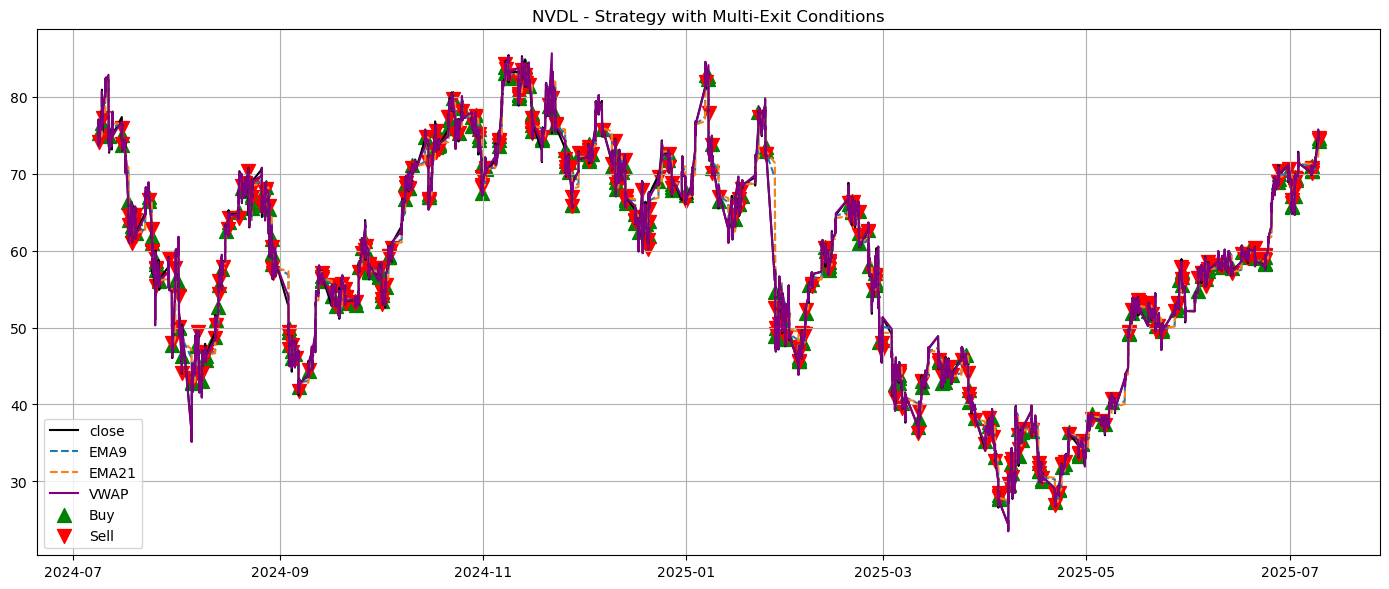

In [29]:

from utils_day_trade import get_latest_data, generate_rsi3070_signals_and_backtest_delay,backtest_plot,max_consecutive_losses
#['TSLL','QQQM','NVDL','AAPL']: 
start_date_str = '2024-07-07'
for ticker in  ['NVDL']: #'TSLL',,'NVDA','TQQQ','GLD']:
 
    print(ticker)
    df = get_latest_data(ticker,start_date=start_date_str)
    df,trades = generate_rsi3070_signals_and_backtest_delay(df,3,40,60)
    backtest_plot(ticker,df,trades)


## dynamic RSI

NVDL
now lower RSI is 39.88314136125656
🔎 回测总结
                     Buy_Time                 Sell_Time  Buy_Price  \
0   2024-07-08 15:50:00+00:00 2024-07-08 16:30:00+00:00     75.330   
1   2024-07-09 17:45:00+00:00 2024-07-09 18:20:00+00:00     76.525   
2   2024-07-15 14:15:00+00:00 2024-07-15 14:35:00+00:00     74.540   
3   2024-07-15 17:00:00+00:00 2024-07-15 17:20:00+00:00     73.510   
4   2024-07-17 13:35:00+00:00 2024-07-17 13:55:00+00:00     66.330   
..                        ...                       ...        ...   
293 2025-07-01 15:55:00+00:00 2025-07-01 16:30:00+00:00     65.820   
294 2025-07-02 18:05:00+00:00 2025-07-02 18:25:00+00:00     69.530   
295 2025-07-07 13:35:00+00:00 2025-07-07 14:10:00+00:00     70.910   
296 2025-07-09 17:50:00+00:00 2025-07-09 18:10:00+00:00     74.330   
297 2025-07-09 18:20:00+00:00 2025-07-09 18:55:00+00:00     74.615   

     Sell_Price    Return         Sell_Reason  
0        74.195 -0.015067        Loss ≤ -0.5%  
1        76.720 

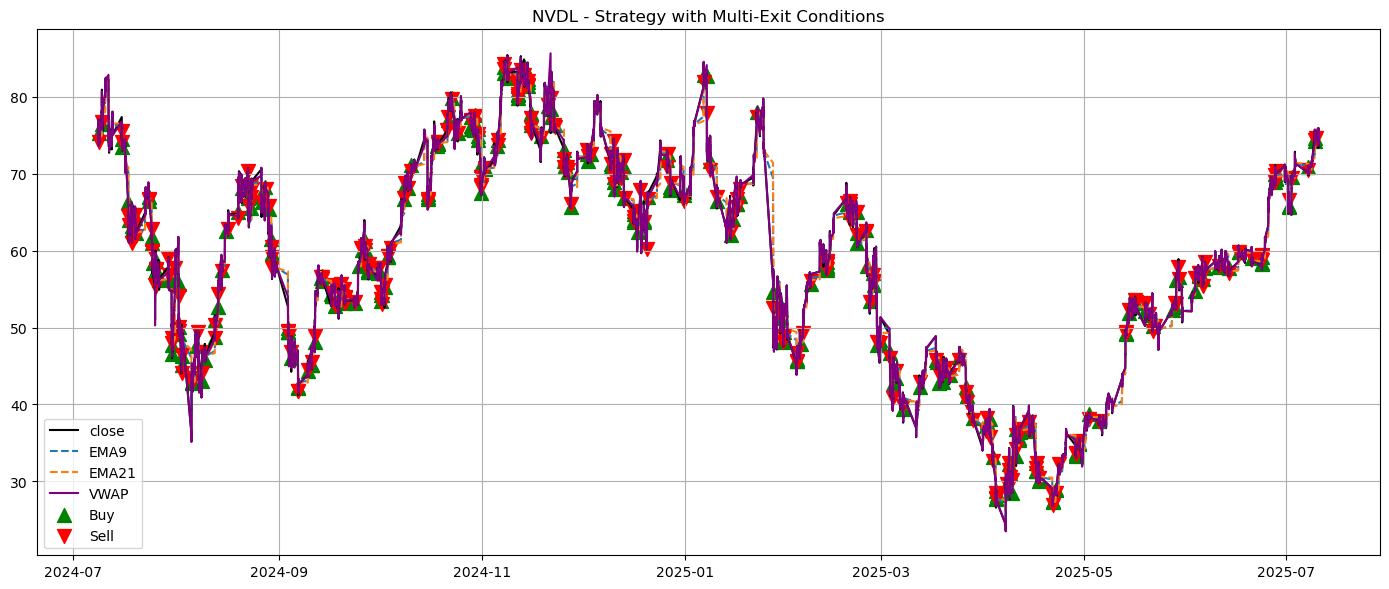

In [27]:
import pandas as pd
from utils_day_trade import get_latest_data, generate_rsi_dynamic_signals_and_backtest_delay,backtest_plot,max_consecutive_losses
#['TSLL','QQQM','NVDL','AAPL']: 
start_date_str = '2024-07-07'
for ticker in  ['NVDL']: #'TSLL',,'NVDA','TQQQ','GLD']:
    print(ticker)
    df = get_latest_data(ticker,start_date=start_date_str)
    df,trades,base_rsi = generate_rsi_dynamic_signals_and_backtest_delay(df,3,40,60)
    print(f'now lower RSI is {base_rsi}')
    backtest_plot(ticker,df,trades)
# 35.48 from one year train

In [47]:
df_trades = pd.DataFrame(trades)
df_trades["Buy_Time"] = pd.to_datetime(df_trades["Buy_Time"], utc=True)  # ensure UTC awareness
df_trades["Buy_Time"] = df_trades["Buy_Time"].dt.tz_convert("America/New_York")  # convert to Eastern Time
df_trades["Sell_Time"] = pd.to_datetime(df_trades["Sell_Time"], utc=True)  # ensure UTC awareness
df_trades["Sell_Time"] = df_trades["Sell_Time"].dt.tz_convert("America/New_York")  # convert to Eastern Time
df_trades.tail(5)

,Buy_Time,Sell_Time,Buy_Price,Sell_Price,Return,Sell_Reason
293,2025-06-27 15:25:00-04:00,2025-06-27 16:10:00-04:00,69.24,69.44,0.002889,RSI ≥ 60
294,2025-07-01 12:00:00-04:00,2025-07-01 12:35:00-04:00,65.61,66.76,0.017528,RSI ≥ 60
295,2025-07-02 14:10:00-04:00,2025-07-02 14:35:00-04:00,69.38,69.37,-0.000144,EMA diff shrinking
296,2025-07-07 09:40:00-04:00,2025-07-07 10:15:00-04:00,70.86,70.89,0.000423,EMA diff shrinking
297,2025-07-09 13:55:00-04:00,2025-07-09 15:00:00-04:00,74.34,74.55,0.002825,EMA diff shrinking


In [32]:

import pandas as pd

# 创建 DataFrame
df_trades = pd.DataFrame(trades)

# 去除时间列的时区（如果存在）
for col in ["Buy_Time", "Sell_Time"]:
    if col in df_trades.columns:
        df_trades[col] = pd.to_datetime(df_trades[col]).dt.tz_localize(None)

# 导出为 Excel


# Get the longest losing streak
max_losing_streak = max_consecutive_losses(df_trades)
print(max_losing_streak)
df_trades.to_excel("NVDL_rsi_method.xlsx", index=False)


6


PermissionError: [Errno 13] Permission denied: 'NVDL_rsi_method.xlsx'

In [33]:
df.tail(5)

,close,high,low,trade_count,open,volume,vwap,timestamp,rsi,ema9,ema21,ema_diff,ema_diff_prev,vol_up,signal_raw,signal,sell_signal_raw,sell_signal,rsi_prev
timestamp,,,,,,,,,,,,,,,,,,,
2025-07-09 19:15:00+00:00,74.60,74.60,74.50,3,74.50,400,74.550000,2025-07-09 19:15:00+00:00,62.871287,74.527801,74.541571,-0.013770,-0.025977,False,0,0.0,0,0,55.357143
2025-07-09 19:20:00+00:00,74.81,74.81,74.80,2,74.80,400,74.802500,2025-07-09 19:20:00+00:00,66.517857,74.584241,74.565974,0.018267,-0.013770,False,0,0.0,0,0,62.871287
2025-07-09 19:25:00+00:00,74.58,74.77,74.58,3,74.77,326,74.643333,2025-07-09 19:25:00+00:00,55.185185,74.583393,74.567249,0.016144,0.018267,False,0,0.0,0,0,66.517857
2025-07-09 19:30:00+00:00,74.50,74.53,74.50,4,74.53,700,74.508571,2025-07-09 19:30:00+00:00,51.418440,74.566714,74.561135,0.005579,0.016144,False,0,0.0,0,0,55.185185
2025-07-09 19:35:00+00:00,74.50,74.56,74.48,4,74.48,700,74.514286,2025-07-09 19:35:00+00:00,45.634921,74.553371,74.555578,-0.002206,0.005579,True,0,0.0,0,0,51.418440
